In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
ticker = 'MSFT'
df = yf.download(ticker,'2020-01-01' )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

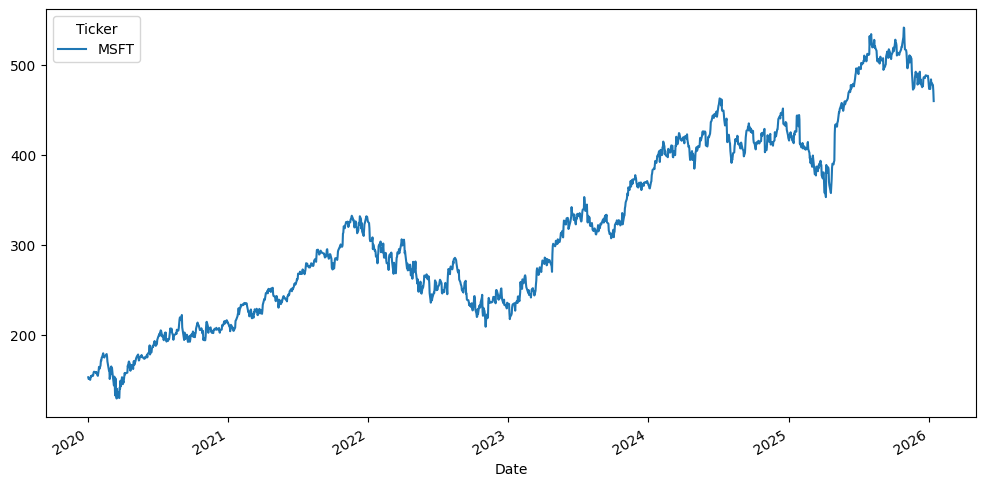

In [4]:
df.Close.plot(figsize=(12,6)) #test

In [5]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df[['Close']])



In [6]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

train_size = int(0.8 *len(data))

X_train = torch.from_numpy(data[:train_size,:-1,:]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)

X_test = torch.from_numpy(data[train_size:,:-1,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:,-1,:]).type(torch.Tensor).to(device)

In [7]:
class PredictionModel(nn.Module):
    def __init__(self, imput_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(imput_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) =  self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [8]:
model = PredictionModel(imput_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [9]:
critereion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [10]:
num_epochs = 2000

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = critereion(y_train_pred,y_train)

    if i % 25 == 0:
        print(i,loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

0 0.7308714389801025
25 0.008424526080489159
50 0.0041082557290792465
75 0.0035791373811662197
100 0.0033509607892483473
125 0.0031739710830152035
150 0.0030121291056275368
175 0.002860476728528738
200 0.0027203047648072243
225 0.002596978796645999
250 0.00249766418710351
275 0.0029922935646027327
300 0.0024900443386286497
325 0.0024001975543797016
350 0.002339435974135995
375 0.0022989436984062195
400 0.002270396100357175
425 0.002249285113066435
450 0.0022328190971165895
475 0.0022193281911313534
500 0.002207973040640354
525 0.0021983759943395853
550 0.0021903133019804955
575 0.0021835665684193373
600 0.0021779099479317665
625 0.002173128305003047
650 0.002169029088690877
675 0.002165452344343066
700 0.0021622732747346163
725 0.0021593966521322727
750 0.002156751463189721
775 0.0021542764734476805
800 0.002151923021301627
825 0.002149659674614668
850 0.0021474873647093773
875 0.0021454317029565573
900 0.0021435001399368048
925 0.0021416516974568367
950 0.0021398398093879223
975 0.002

In [11]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
x_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
x_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [12]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(x_test[:,0], x_test_pred[:,0])



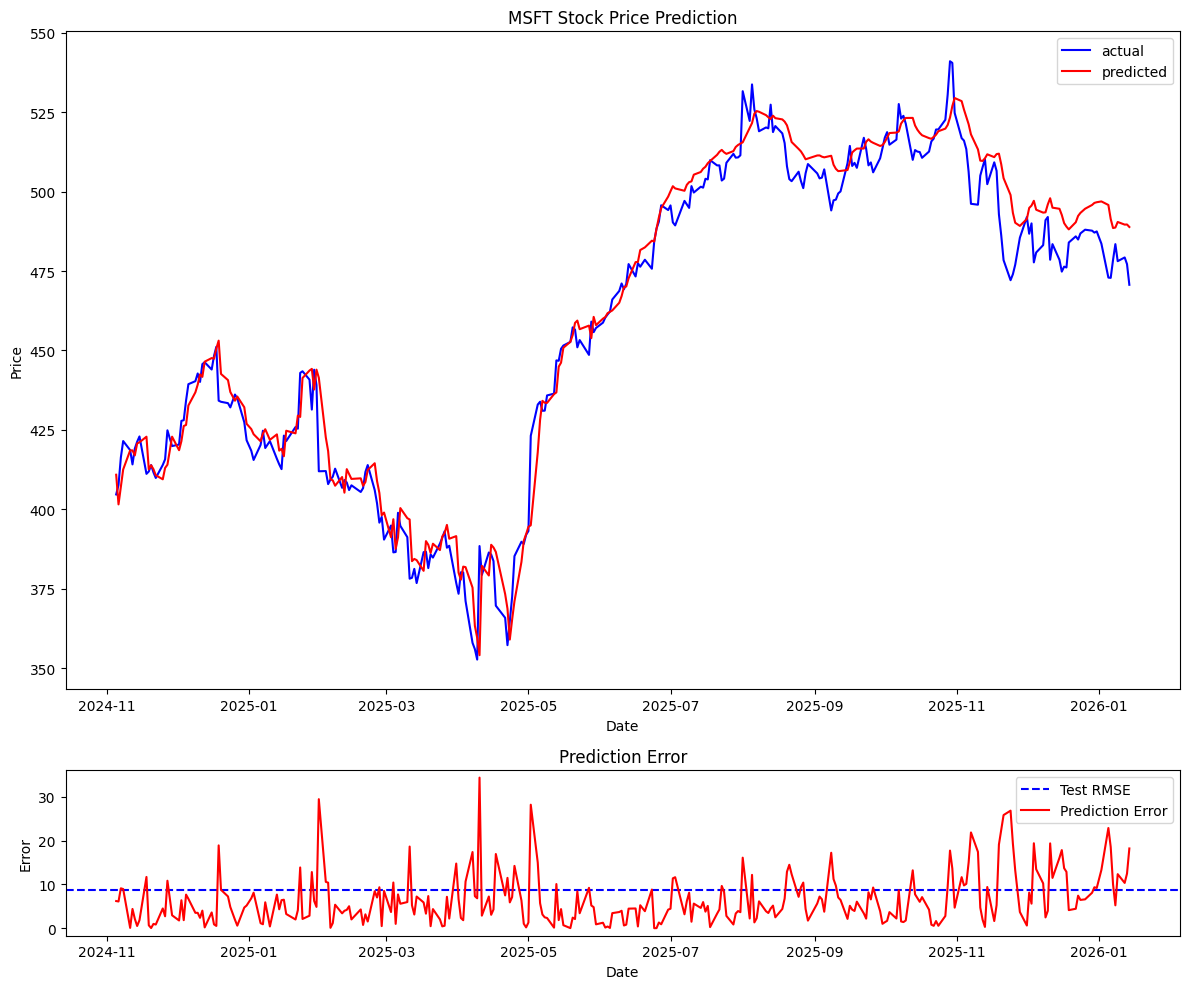

In [13]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[0:3,0])

ax1.plot(df.iloc[-len(x_test):].index, x_test[:,0], color = 'blue',label = 'actual')
ax1.plot(df.iloc[-len(x_test_pred):].index, x_test_pred[:,0], color = 'red', label = 'predicted')
ax1.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse,color = 'blue', linestyle='--', label = 'Test RMSE')
ax2.plot(df.iloc[-len(x_test):].index, np.abs(x_test[:,0]-x_test_pred[:,0]), color = 'red', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()